## 1 - Importing necessary libraries for Jupyter lab
These lines in a Jupyter Lab notebook are used to automatically reload Python modules before executing code, which is particularly useful during development. Here’s what each line does:

1. **`%load_ext autoreload`**:
   - This line loads the `autoreload` extension. The `autoreload` extension is part of the IPython system (which Jupyter is built on top of) and allows you to automatically reload modules that have been imported when they are modified. This means you don’t need to restart your kernel or manually reload modules every time you make a change to the source code.

2. **`%autoreload 2`**:
   - This line sets the `autoreload` mode to 2. The `autoreload` extension has three modes:
     - **`0`**: Disable `autoreload`.
     - **`1`**: Reload all modules imported with `%aimport` every time before executing the Python code typed.
     - **`2`**: Reload all modules (except those excluded by `%aimport`) every time before executing the Python code typed.
   
   By setting the mode to `2`, you are instructing Jupyter to reload all imported modules automatically before executing any cell. This ensures that any changes made to the code in the modules are reflected immediately without needing to restart the kernel or manually reload the modules.

This makes the development process smoother and more efficient, especially when you are iterating quickly and making frequent changes to your code.


In [1]:
%load_ext autoreload
%autoreload 2

## 2 - Problem definition
Let us think of a problem involving a cylindrical solid body cooling in an open environment. We can think of this as a very thin coffee cup cooling with the environment. 

### Involved equations
Therefore, the environmental temperature is defined as $T_{{env}}$ and the temperature of the hot liquid at a time $t=0$ given as $T_0$. The governing equation for this relation is,

$$\frac{dT}{dt} = R \times (T - T_{env})$$

### 2.1 - Assumptions 
To use the equation to perform necessary resolution, we need assumptions to limit our application.

1. **Uniform Temperature throughout the Body**: The temperature \( T(t) \) is assumed to be uniform throughout the entire body of the coffee cup at any given time \( t \). This assumes efficient thermal conduction within the body of the cup.

2. **Thin-Walled Approximation**: If the coffee cup is thin-walled relative to its diameter, heat conduction through the walls can be approximated as instantaneous, meaning the temperature throughout the wall thickness is uniform.

3. **Isotropic Heat Conduction (if applicable)**: The coffee cup is assumed to conduct heat uniformly in all directions (isotropically), which simplifies the heat transfer analysis.

4. **Environment Size**: The size of the environment relative to the coffee cup is large enough such that the temperature ($T_{env}$) remains constant over time and does not significantly change due to the heat lost by the coffee cup.

6. **No Phase Change**: The material of the coffee cup and the liquid inside do not undergo phase changes (like boiling) during the cooling process. This assumption simplifies the analysis to a single-phase heat transfer process.

7. **Steady-State Conditions**: The system is assumed to be in a steady-state condition at the initial time \$t = 0$), where the temperature difference between the coffee cup and the environment drives the initial rate of cooling.

### 2.2 - Analytical and numerical solution

Since this is a linear differential equation a combination of homogeneous and particular solutions exists. Below solution calculates the temperature ($T$) of an object at a given time based on Newton's Law of Cooling. It uses the ambient temperature ($T_{{env}}$), the initial temperature ($T_0$), the coefficient of heat transfer ($R = \frac{hA}{C}$), and the elapsed time to compute the temperature.

$$T = T_{env} + (T_0 + T_{env}) \cdot e^{-Rt}$$

Suppose, a liquid has a temperature of 99 degrees at a $t = 0$. The environment temperature, $T_{env}$ measured as $25^o$. We would like to know the temperature evolution and time spent until the whole liquid temperature reaches an equilibrium with the environment temperature. However, the coefficient of heat transfer, $R$, should be supplied to the equation. So, we can have,

* An analytical solution by using Neumann and Dirichlet boundary condition.
* A numerical solution is obtained using SciPy. A hand calculation on numerical solution can be obtained via using Euler's method $T{i+1}=T_i + h(−R(T_i - T_{env}))=T_i − Rh(T_i - T_{env})$. The hand calculation is not implemented here. 

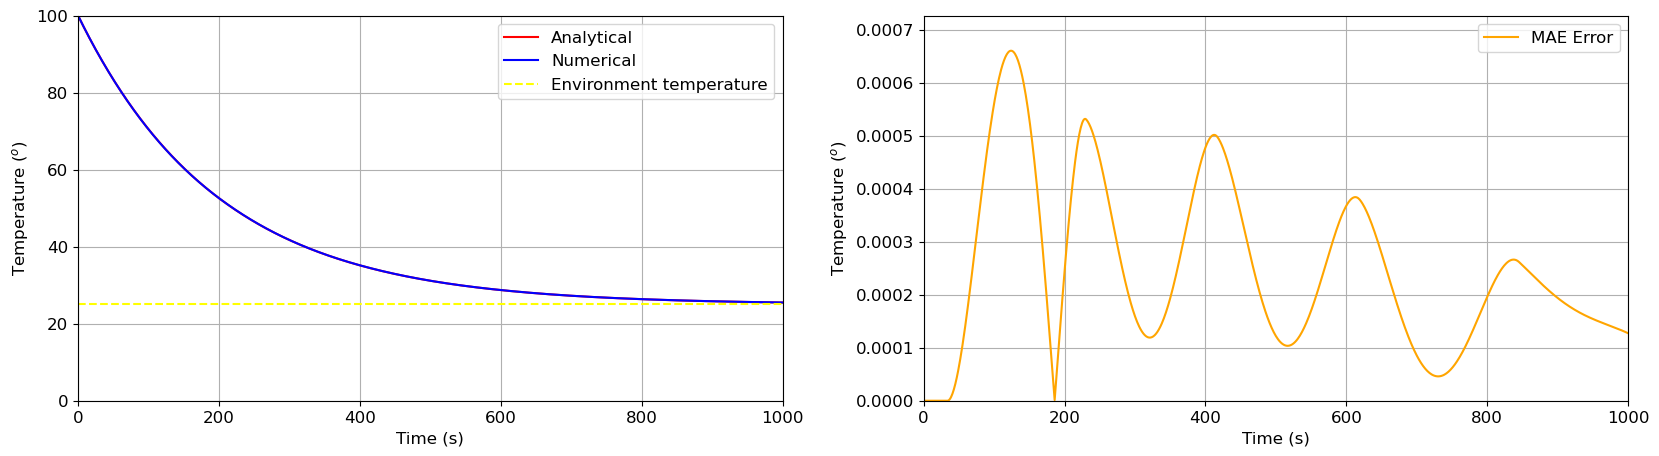

In [2]:
from soln import *
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame()

p = Soln(Tenv = 25, T0=100, cooling_rate = 0.005, t_start = 0.0, t_end = 1000.0, increment = 1.0)
data["time"] = p.get('time_data')
data["analytical"] = p.analytical_solution()
data["numerical"] = p.numerical_solution()
data["mae_error"] = abs((p.analytical_solution() -  p.numerical_solution()) / p.analytical_solution())

## Plotting of data
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs[0].plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs[0].axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlim(0,data["time"].max())
axs[0].set_ylim(0,data["analytical"].max())
axs[0].set_xlabel("Time (s)", fontsize = 12)
axs[0].set_ylabel("Temperature ($^o$)", fontsize = 12)
axs[0].grid()
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].plot(data["time"], data["mae_error"], linestyle="solid", color="orange", label="MAE Error")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_xlabel("Time (s)", fontsize = 12)
axs[1].set_ylabel("Temperature ($^o$)", fontsize = 12)
axs[1].grid()
axs[1].set_xlim(0,data["time"].max())
axs[1].set_ylim(0,data["mae_error"].max()*1.1)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

From the results, it looks like we have a good resolution in between analytical and numerical solution. The mean absolute error (MAE) between two solution is compared. The form of the MAE looks like a quadratic evolution on each point. This is due to usage of Runge-Kutta method during the resolution on scipy functions.

## 3 - Classical neural network approach to regenerate Newton's Law of Cooling
For this designated simple problem, the Newton Law of Cooling can be applied to understand the temperature evolution behavior. But, is it possible to give some of the data to the machine learning libraries and expect to extrapolate the variables with the same behavior?

To test this idea, we can use the PyTorch package to constrµuct our neural network and test it. Since we are constructing the neural network by hand, it is possible to use functions of PyTorch library including optimizers.

### 3.1 - Train and test data
To train our cooling behavior described in our equation, training data on the first part of the curve can be used.

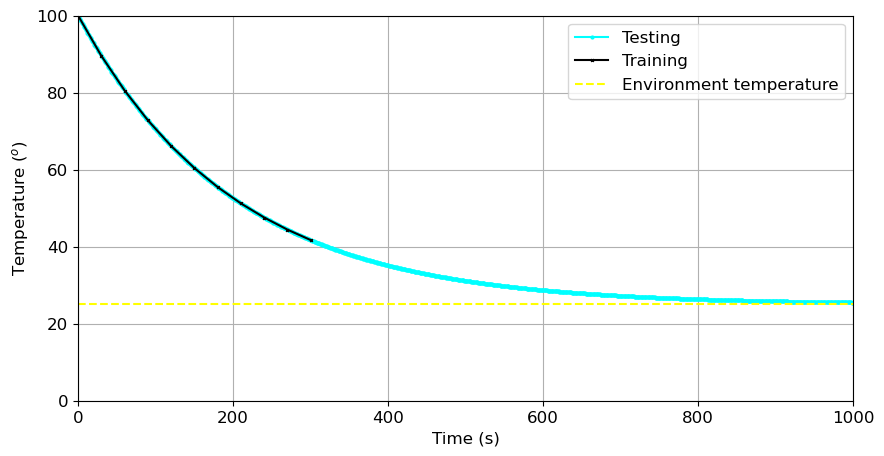

In [49]:
# Generate training data
number_of_data = 10
get_values = list(range(int(0), int(300) + 1, int(300/number_of_data)))
training_data = data[data['time'].isin(get_values)]
training_data = training_data.reset_index()

# Generate testing data
testing_data = data[~data['time'].isin(get_values)]
testing_data = testing_data.reset_index()

# Plot training and testing data
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
axs.plot(testing_data["time"], testing_data["analytical"], linestyle=None, marker="o", color="cyan", markersize = 2, label="Testing")
axs.plot(training_data["time"], training_data["analytical"], linestyle=None, marker="x", color="black", markersize = 2, label="Training")
axs.axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs.legend(loc='upper right', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)", fontsize = 12)
axs.set_ylabel("Temperature ($^o$)", fontsize = 12)
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)
axs.grid()

### 3.2 Import necessary libraries and run a neural network application
Let's start with including the necessary libraries. This code snippet is also used to automatically determine and display the computing device being used by PyTorch, either a CUDA-enabled GPU or the CPU. It first checks if a CUDA-capable GPU is available and sets the device accordingly. If a GPU is being used, it prints the GPU's name and the memory usage, including the amount of memory allocated and reserved (cached) in gigabytes. This is useful for monitoring and debugging purposes in deep learning applications to ensure that the GPU resources are being utilized correctly. 
* The class Net defines a neural network in PyTorch, with configurable input and output dimensions, hidden units, loss functions, learning rate, and training epochs. The network architecture consists of several ReLU-activated linear layers. The fit method trains the network using the Adam optimizer, while optionally considering a secondary loss term. The predict method outputs the network's predictions for given input data. 
* The NetDiscovery class extends the Net class, inheriting its neural network structure and training functionality. In addition to the inherited attributes, it introduces a new learnable parameter r.

In [91]:
from nn import Net, NetDiscovery

## The parameter added here is to ensure everything is in the same device
preferred_device = "cpu"

## Construct the neural network
net = Net(input_dim = 1, output_dim = 1, 
          loss2=None, epochs=20000, lr=1e-5)

Using device: cuda
NVIDIA T1000 8GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [93]:
## Assign the computation to GPU or CPU
## If required to change the device than use
## net.set_device("cpu") or net.set_device("cuda")
## Before the line below
net.set_device(preferred_device)
net = net.to(preferred_device)

## There is not a big difference between GPU and CPU
## Unless the tensor size gets bigger

## Calculate losses
losses = net.fit_tqdm(training_data["time"].values, training_data["analytical"].values)

Training Progress: 100%|██████████████████████████████████████| 20000/20000 [00:14<00:00, 1360.21it/s]


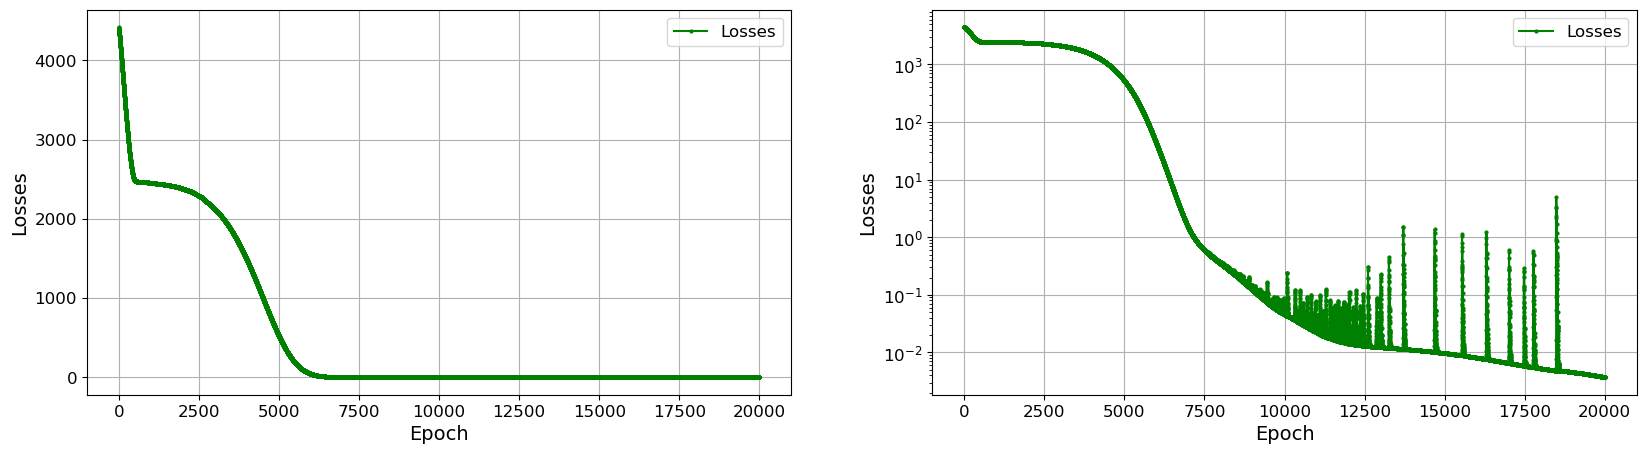

In [94]:
## Plot losses
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(losses, linestyle=None, marker="o", color="green", markersize = 2, label="Losses")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Losses", fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid()

axs[1].plot(losses, linestyle=None, marker="o", color="green", markersize = 2, label="Losses")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_yscale('log')
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Losses", fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid()

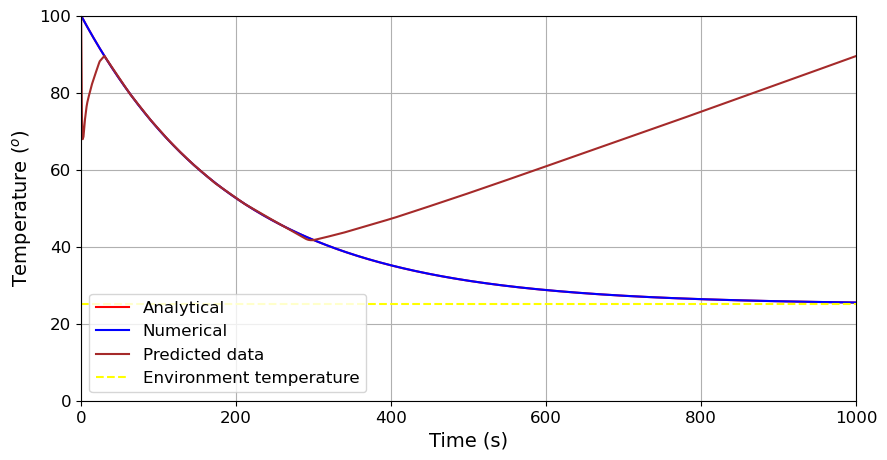

In [95]:
## Plot predictions

data['temperature_prediction'] = net.predict(data['time'].to_numpy())

## Plotting of data
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
axs.plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs.plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs.plot(data["time"], data['temperature_prediction'], linestyle="solid", color="brown", label="Predicted data")
axs.axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs.legend(loc='lower left', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Temperature ($^o$)", fontsize=14)
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)
axs.grid()

### 3.3 - Re-running the neural network with l2 regularization
This time, we will add a l2 regularization on neural network by using the function 'l2_reg'.
If you run the code below, you can sense that the execution time of the same code increased. It is because, on each epoch we have to access a function and make calculations.

In [96]:
from nn import l2_reg

## Construct the neural network
net_l2 = Net(input_dim = 1, output_dim = 1, 
             epochs=50000, lr=1e-5,
             loss2=l2_reg, loss2_weight = 1.)

Using device: cuda
NVIDIA T1000 8GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [97]:
## Assign the computation to GPU or CPU
## If required to change the device than use
## net.set_device("cpu") or net.set_device("cuda")
## Before the line below
net_l2.set_device(preferred_device)
net_l2 = net_l2.to(preferred_device)

## There is not a big difference between GPU and CPU
## Unless the tensor size gets bigger

## Calculate losses
losses_l2 = net_l2.fit_tqdm(training_data["time"].values, training_data["analytical"].values)

Training Progress: 100%|███████████████████████████████████████| 50000/50000 [01:15<00:00, 658.55it/s]


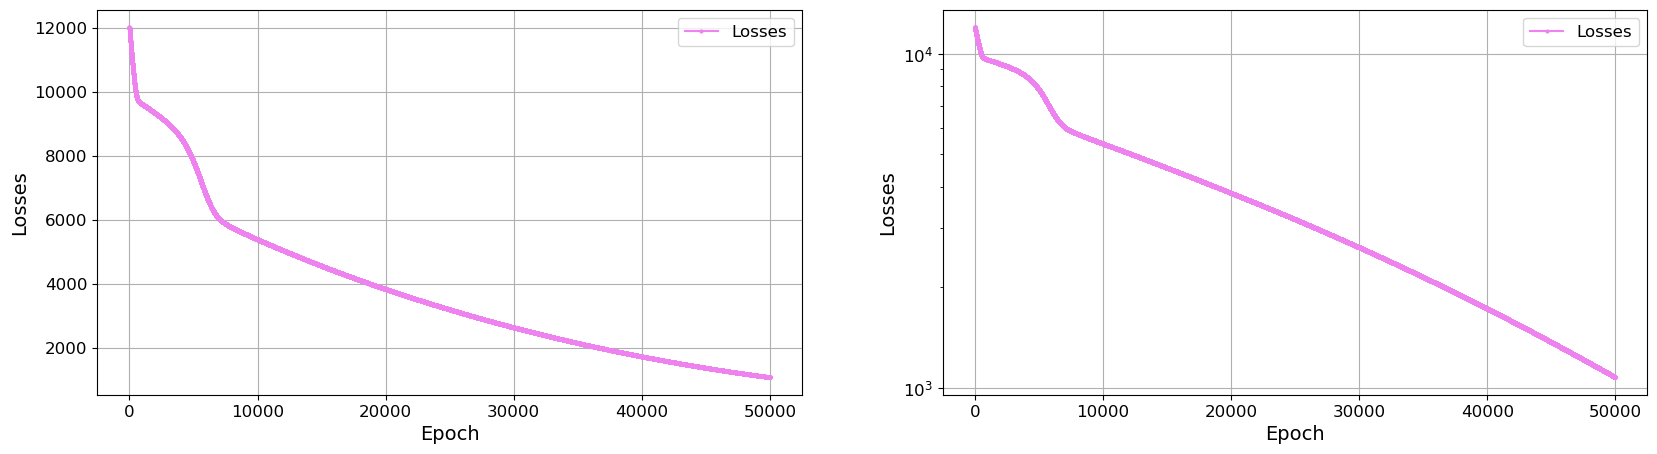

In [98]:
## Plot losses
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(losses_l2, linestyle=None, marker="o", color="violet", markersize = 2, label="Losses")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Losses", fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid()

axs[1].plot(losses_l2, linestyle=None, marker="o", color="violet", markersize = 2, label="Losses")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_yscale('log')
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Losses", fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid()

Compared to l1 regularization, it seems that we require more epoch to reach stability on the losses. But, for the sake of simplicity, we leave the results as it is.

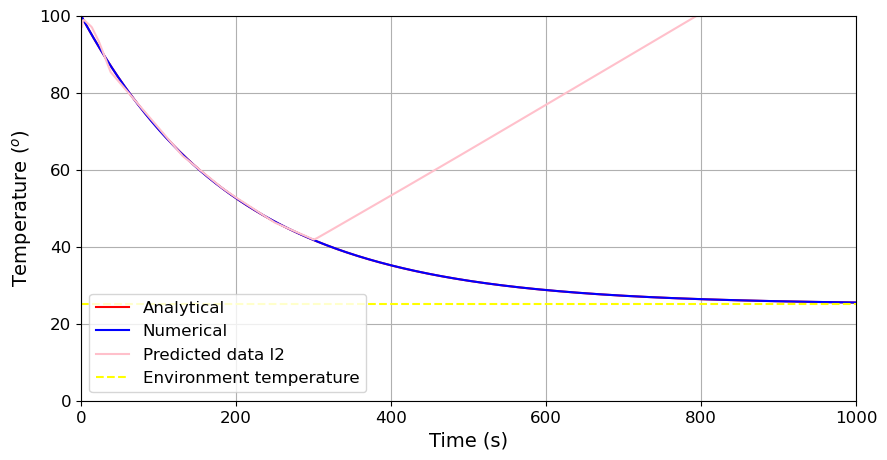

In [99]:
## Plot predictions

data['temperature_prediction_l2'] = net_l2.predict(data['time'].to_numpy())

## Plotting of data
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
axs.plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs.plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs.plot(data["time"], data['temperature_prediction_l2'], linestyle="solid", color="pink", label="Predicted data l2")
axs.axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs.legend(loc='lower left', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Temperature ($^o$)", fontsize=14)
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)
axs.grid()

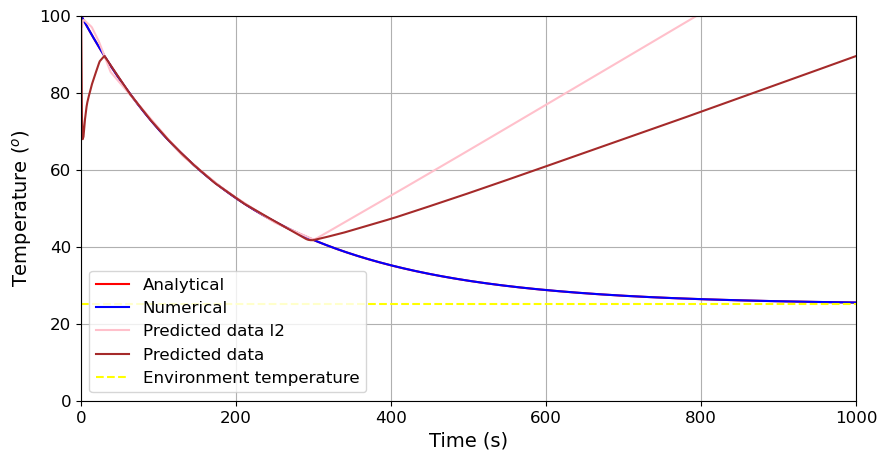

In [100]:
## Let us plot them all
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
axs.plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs.plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs.plot(data["time"], data['temperature_prediction_l2'], linestyle="solid", color="pink", label="Predicted data l2")
axs.plot(data["time"], data['temperature_prediction'], linestyle="solid", color="brown", label="Predicted data")
axs.axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs.legend(loc='lower left', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Temperature ($^o$)", fontsize=14)
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)
axs.grid()

## 4 - Neural network approach with PINN method
This time we will use the same neural network configuration. But, this time, the l2 regularization will be modified. To do that, we will require to define a physics loss to obey. 

In [101]:
## Make sure that the start_time, end_time and the steps corresponds to the total number of sampling
import torch
from torch.autograd import grad

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def physics_loss(model: torch.nn.Module, device = preferred_device, cooling_rate = 0.005, Tenv = 25):
    # Create a 1D tensor of 1000 evenly spaced values from 0 to 1000.
    # Reshape it to have 1000 rows and 1 column, and set requires_grad to True
    # so that we can compute gradients for this tensor later.
    ts = torch.linspace(0, 1000, steps=1000).view(-1, 1).requires_grad_(True).to(device)
    
    # Pass the time tensor 'ts' through the model to get the temperature predictions.
    temps = model(ts)
    
    # Compute the gradient of the temperature predictions 'temps' with respect to 'ts'.
    # This gives the rate of change of temperature over time, denoted as 'dT'.
    #dT = grad(temps, ts, grad_outputs=torch.ones_like(temps), create_graph=True)[0]
    dT = grad(temps, ts)[0]
    
    # Define the residual of the PDE.
    # 'R' is a constant representing some physical parameter (assumed to be defined elsewhere).
    # 'Tenv' is a constant representing the environment temperature (assumed to be defined elsewhere).
    # The PDE residual is given by R * (Tenv - temps) - dT.
    pde = cooling_rate * (Tenv - temps) - dT
    
    # Calculate the mean of the squared PDE residuals.
    # This value represents the loss, quantifying how well the model satisfies the PDE.
    return torch.mean(pde**2)

In [102]:
## Construct the neural network
net_pinn = Net(input_dim = 1, output_dim = 1, 
          loss2=physics_loss, epochs=30000, lr=1e-5)

Using device: cuda
NVIDIA T1000 8GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [103]:
## Assign the computation to GPU or CPU
## If required to change the device than use
## net.set_device("cpu") or net.set_device("cuda")
## Before the line below
net_pinn.set_device(preferred_device)
net_pinn = net_pinn.to(preferred_device)

## There is not a big difference between GPU and CPU
## Unless the tensor size gets bigger

## Calculate losses
losses_pinn = net_pinn.fit_tqdm(training_data["time"].values, training_data["analytical"].values)

Training Progress: 100%|███████████████████████████████████████| 30000/30000 [01:15<00:00, 395.21it/s]


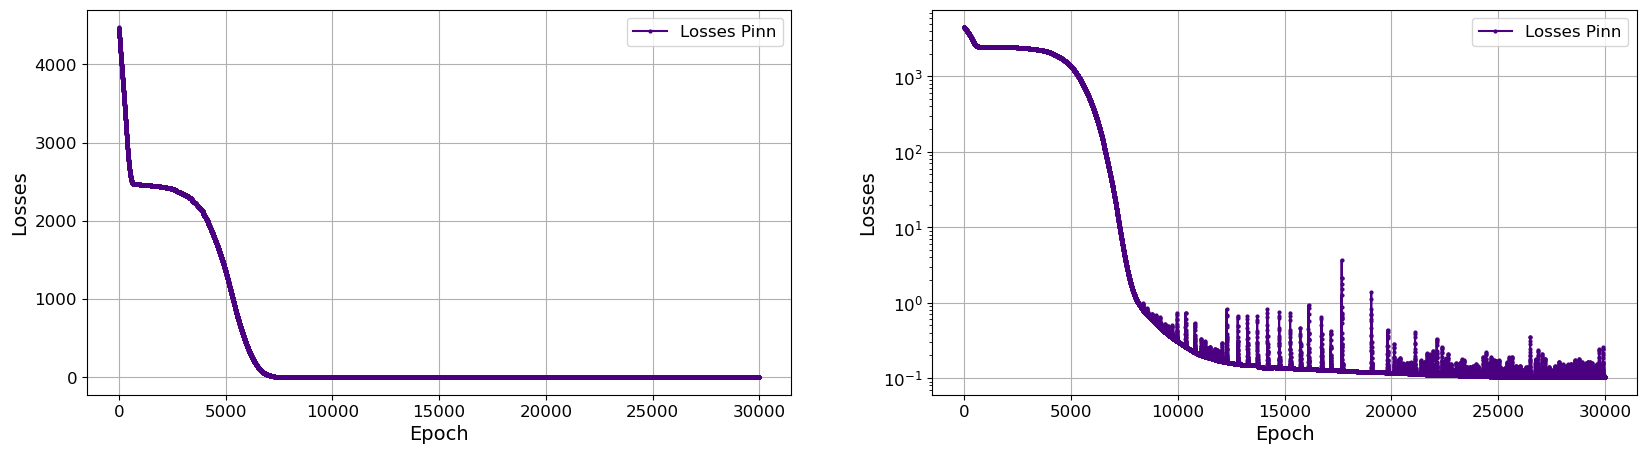

In [104]:
## Plot losses
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(losses_pinn, linestyle=None, marker="o", color="indigo", markersize = 2, label="Losses Pinn")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Losses", fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid()

axs[1].plot(losses_pinn, linestyle=None, marker="o", color="indigo", markersize = 2, label="Losses Pinn")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_yscale('log')
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Losses", fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid()

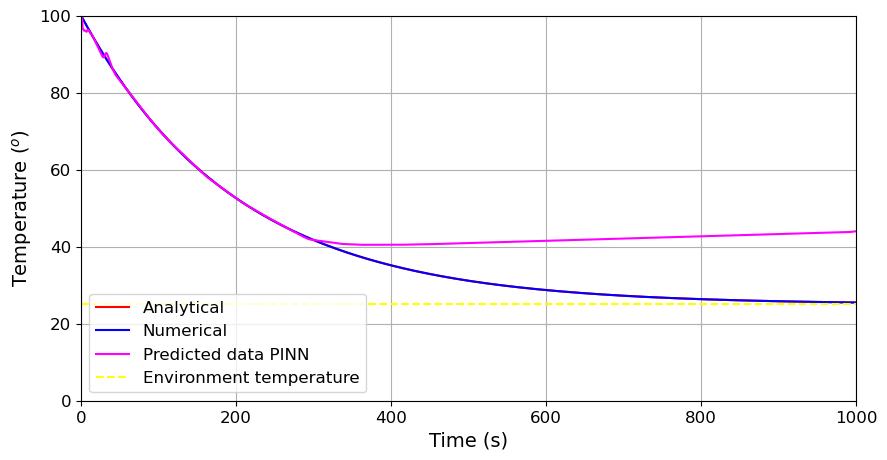

In [105]:
## Plot predictions

data['temperature_prediction_pinn'] = net_pinn.predict(data['time'].to_numpy())

## Plotting of data
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
axs.plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs.plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs.plot(data["time"], data['temperature_prediction_pinn'], linestyle="solid", color="magenta", label="Predicted data PINN")
axs.axhline(y = 25, color = 'yellow', linestyle = '--', label = "Environment temperature") 
axs.legend(loc='lower left', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Temperature ($^o$)", fontsize=14)
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)
axs.grid()

## Parameter Discovery

In [ ]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

In [ ]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

In [ ]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')